## Problem Statement
This project aims to mitigate the communication challenges faced by the deaf and hard of hearing community by employing deep learning techniques to classify images of the sign language alphabet into their respective letter labels and display them to the user. 

By leveraging the sophisticated capabilities of deep learning and neural networks, the project presents two model that are designed to interpret and translate sign language gestures into text, thereby enhancing accessibility in digital communication between deaf and non-deaf people. The project aims to create a tool (the best of the two approaches) that can be integrated into various digital platforms, ultimately bridging the communication gap between individuals who rely on sign language and those who dont have experience with it to promoting inclusivity in digital interactions for those who rely on sign language.

This is approach 1 of 2, a custom Convolutional Neural Network model with images as inputs.

## Data Source 

Initially, our project explored the Sign Language MNIST dataset. However, we found this dataset to be heavily processed and unsuitable for our needs. Further research led us to the American Sign Language (ASL) Alphabet dataset, which we identified as more appropriate. This dataset is available on Kaggle at: https://www.kaggle.com/datasets/grassknoted/asl-alphabet?fbclid=IwAR3ThX3ffncTvf8qGfX0-fCw3O93LvYsk2LpLlWLGVXI4tWvBW9zXKdw-qc. Specifically, we utilised the "asl_alphabet_train" folder from this source as our full dataset for our project.

In [1]:
# README CELL 1.1
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

/Users/oguzhanlt/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploratory Analysis of Data

Please note: When original dataset is mentioned, it means the dataset before pre-processing steps.

The original dataset consisted of 87,000 images of the American Sign Language Alphabet characters. These images are organised into 29 distinct folders, indexed from 0 to 28, where 26 of the folders contain images corresponding to letters in the American sign language alphabet and 3 extra classes consisting of special characters. These folders combined correspond to the 29 classes in our model. The inclusion of 3 extra folders of images and as a result the three extra classes, in addition to the standard 26 American alphabet letters come from inclusion of images representing the special characters "space", "del" (delete) and "nothing" where the "nothing" folder consists of just background images and no hands. Each of the folders in the original dataset consisted of 3000 unique images of the corresponding folder name character. 

We concluded that due to the large size of the dataset that we want to train this model using Kaggle and their GPU's. The dataset size was the most challenging aspect of the data as even with access to Kaggle's GPU's however, the original dataset proved to be just too large for the training process and for the computing power that was available to us. To overcome this problem, we decided to keep every third image in each folder and remove the rest, resulting in our new reduced dataset where there is 1000 images per folder and a total of 29000 images in the new reduced dataset. This dramatically reduced the computational load required to train our model which has a relatively simple architecture. 

As for the properties of the individual images, in the execution output of the code cell below, we can see that the images have 200 x 200 pixel dimensions as represented but the first two numbers in the brackets and they are colour images, which can be deduced from the last number in the brackets, indicating 3 colour channels.

In [12]:
# Image properties
example_image = cv2.imread('../datasets/training_data/A/A3.jpg')
print(example_image.shape)


(200, 200, 3)


# CNN Model Implementation

The cell below defines our CNN model and architecture. As the viewer can see it consists of 4 Convolution layers, 4 max pooling layer and utilises the ReLU activation function after each convolution layer. Starting with 32 filters and a 5 x 5 kernel for the first two convolution layers, the architecture steps up the filter count to 64 filters for the last two convolution layers and also drops the kernel size to 3 x 3. The network then concludes with a fully connected layer of 6400 nodes and an output layer of 29 nodes followed by the LogSoftmax activation function.

In [3]:
# README CELL 1.2
class NetConv(nn.Module):
    def __init__(self):
        super(NetConv, self).__init__()
        self.main = nn.Sequential(
            
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),        
            nn.Linear(6400,29),         
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        output = self.main(x)
        return output

Below is a diagram of our CNN architecture to assist in visualization.

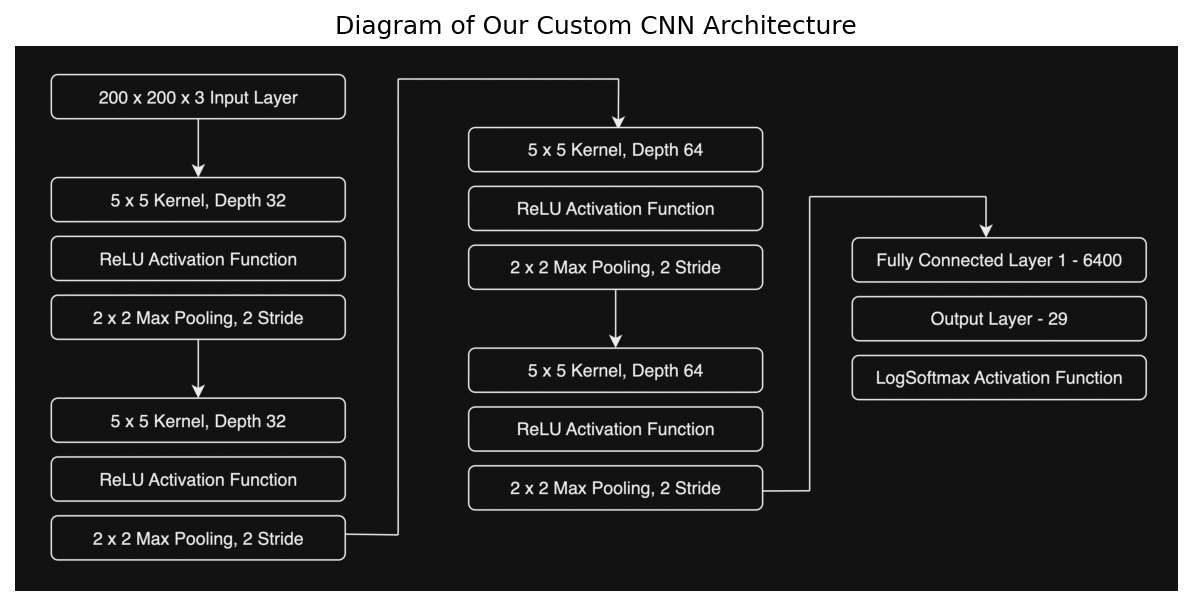

In [15]:
example_image = cv2.imread('CNN_architecture_diagram.png')
plt.figure(figsize=(10, 10), dpi=150)
plt.title("Diagram of Our Custom CNN Architecture")
plt.axis('off')
plt.imshow(example_image)
plt.show()

The cell below consists of the definition of a standard training loop function for a neural network. It iterates through batches for a given epoch, computes the cross-entropy loss, performs backpropagation, and updates the model parameters. For every 100th batch it prints the loss function value. At the end of each epoch, it prints the loss of the last batch, and the overall training accuracy. The function skeleton was taken from COMP9444, Assignment 1 (23T3) and COMP9444, Lecture 2b (PyTorch) and parts of it were changed to suit our needs when solving our problem. These parts include:
- The loss function being changed to Cross Entropy Loss.
- Changing the frequency of logging training progress to a lower frequency to avoid output clutter.
- Printing the loss and training accuracy at the end of each epoch.

In [4]:
def train(net, device, train_loader, optimizer, epoch):
    net.train()
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target)                 
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100*correct/total
    if epoch % 1 == 0:
        print('Train Epoch:%5d loss: %6.4f acc: %5.2f' % (epoch,loss.item(),accuracy))
    return accuracy

The cell below consists of the definition of a standard testing loop function for a neural network. At the end of testing, the function prints a confusion matrix of the classification of samples in the test set, which allows the viewer to understand how well the model is performing on the test set and how the learning and generalising is progressing through the epochs. It also prints the loss function value for the test set which allows the viewer to see how far the predictions of the model ate from the actual ground truth labels. The function skeleton was taken from COMP9444, Assignment 1 (23T3) and Lecture 2b (PyTorch) and parts of it were changed to suit our needs when solving our problem. These parts include:
- The loss function being changed to Cross Entropy Loss.
- The confusion matrix being changed to 29 x 29 and labels being in the range of 0 to 28 (inclusive) to account for the dataset and its classes

In [5]:
def test(net, device, test_loader):
    net.eval()        
    conf_matrix = np.zeros((29,29))       
    test_loss = 0
    correct = 0

    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            loss = F.cross_entropy(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(target.cpu(),pred.cpu(),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])
        np.set_printoptions(precision=4, suppress=True)
        print(conf_matrix)
        net.train()

    loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

The cell below defines the main body of our program and prepares the necessary variables to train our model after we have initialised it. The first if statement checks if there is a GPU available and selects it if there is. Otherwise, it selects the CPU as the device. Although we train our model using Kaggle's GPUs, the inclusion of the if statement to check for both cases ensures that any user trying to run our program can, even if they dont have access to a GPU. However please note, the training times will be significantly longer with CPU usage. 

The next line of code creates and initialises our custom CNN object as defined earlier. The line after that declares the optimizer we are using. We decided to go with Stochastic Gradient Descent (SGD) as we have found better performance using SGD over other optimizers like Adam. As for the learning rate and momentum values, we found that the commonly used values of 0.01 for the learning rate and 0.95 for the momentum was also a good fit for training our model.

The next block of code is our data transformations which is also a part of our pre-processing. The ToTensor() method converts the images in the dataset to tensors, and scales the pixel values down to a range between 0.0 and 1.0, preparing them to be fed into the network in the appropriate format. The Normalize() method then normalises the images by subtracting a mean of 0.5 from each pixel in each channel and then dividing each pixel in each channel by 0.5. The pre-processing step of normalising our data has a number of great benefits for the training process. These benefits include but arent limited to, faster convergence speed to optimum in the training process, reduction in the chance of getting stuck in a local minima in the loss landscape and preventing numerical instability by removing the possibility of large error gradients. 

The next few blocks of code are dataset preparation. The program first imports the dataset, applying our pre-defined data transformations and stores it in the dataset variable. Then we get the indices and extract targets from the dataset and use this information to execute a stratifies split of the whole dataset into 80% training set and 20% test set, all the while ensuring that the two sets have the same proportions of classes as the original dataset. Then we create a DataLoader for the training and test sets and load them in. The choice of setting the shuffle argument to True for the train loader ensures that the training data will be shuffled at every epoch to help prevent the model from learning the order of the data and we went with a common batch size of 64.

Finally we have the last line of code with the epoch variable. This sets the number of epochs that the model will be trained for. After a few trials and training runs with epochs in the range of 10-15, we found that 13 epochs was the sweet spot number and provided is with good training set and test set accuracies.

In [6]:
# Main

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU...")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU...")

net = NetConv().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.95)

# Load and give in datasets
data_transforms = transforms.Compose([  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

data_path = '../datasets/training_data'

dataset = ImageFolder(root=data_path, transform=data_transforms)

indices = list(range(len(dataset)))

targets = [label for _, label in dataset.samples]

train_indices, test_indices, _, _ = train_test_split(
    indices,
    targets,
    stratify=targets,
    test_size=0.2
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

epochs = 13

GPU is available. Using GPU...


# Results

The cell below contains the main training and testing loop of our program for our model. As we can see in the output of the cell, for each epoch at every 100th batch, the batch loss is displayed, along with how much of the training data in that epoch has been seen. Finally, at the end of each epoch the test set confusion matrix, test loss and test set accuracy is printed.

As we can see from the first epoch output metrics, while the training accuracy is relatively low at about 31.17%, the models performs really well on the test set with a test set accuracy of 66%. Throughout the training process from the output metrics we can see the increase in both the training set accuracy and the test set accuracy and fast convergence to a global optimum. In the final epoch, we can see that the network has exceptional performance on our test data with an outstanding test accuracy of 97% suggesting the model has learned the task well and strongly indicates the model's ability to generalise to new, unseen data. Looking at the final confusion matrix we can see some miss classification still occurring but it is relatively low compared to the correct classification count and achieving 100% accuracy is not feasible in the context.

In [8]:
for epoch in range(1, epochs + 1):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader)

Train Epoch: 1 [0/23200 (0%)]	Loss: 3.372704
Train Epoch: 1 [6400/23200 (28%)]	Loss: 3.140700
Train Epoch: 1 [12800/23200 (55%)]	Loss: 2.445396
Train Epoch: 1 [19200/23200 (83%)]	Loss: 1.131202
Train Epoch:    1 loss: 1.5771 acc: 31.17
<class 'numpy.ndarray'>
[[145.  11.   2.   3.   3.   0.   1.   0.   0.   0.   0.   8.   6.   0.
    7.   0.   0.   0.   1.   1.   0.   0.   5.   1.   2.   1.   0.   3.
    0.]
 [  9. 153.   0.   7.   7.   2.   0.   0.   0.   0.   1.   2.   3.   0.
    0.   0.   0.   1.   0.   0.   1.   0.  12.   0.   0.   0.   0.   2.
    0.]
 [  0.   0. 173.   0.   0.   0.   1.   0.   0.   1.   0.   6.   1.   0.
    1.   9.   7.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
    0.]
 [  4.  11.   3. 154.   1.   4.   0.   0.   0.   0.   1.   9.   3.   0.
    6.   0.   0.   0.   0.   0.   0.   0.   2.   0.   0.   0.   2.   0.
    0.]
 [ 17.  32.   0.   6.  87.   2.   0.   0.   0.   0.   1.  14.  12.   2.
    4.   0.   0.   0.   7.   0.   1.   0.  12.   3.   0.   0

The below map_integer_to_string(key) function is just a mapping function from the class numbers to the class character labels.

In [4]:
# README CELL 1.3
def map_integer_to_string(key):
    mapping = {
        0: "A",
        1: "B",
        2: "C",
        3: "D",
        4: "del",
        5: "E",
        6: "F",
        7: "G",
        8: "H",
        9: "I",
        10: "J",
        11: "K",
        12: "L",
        13: "M",
        14: "N",
        15: "nothing",
        16: "O",
        17: "P",
        18: "Q",
        19: "R",
        20: "S",
        21: "space",
        22: "T",
        23: "U",
        24: "V",
        25: "W",
        26: "X",
        27: "Y",
        28: "Z"
    }
    
    return mapping.get(key)


The code in the cell below just saves the weights of the trained model so we can load it again and use it when needed, just like we will be doing in the following inference section.

In [6]:
# SAVING SUCCESSFULLY TRAINED WEIGHTS
torch.save(net.state_dict(), 'New_Trained_Weights.pth')

## Inference Tests

The following inference tests are conducted on images that the model has never seen before. These images are sourced from Kaggle, as mentioned earlier in the notebook, specifically from the 'asl_alphabet_test' folder.

In preparation for the inference, the code block below begins by instantiating a new object of our custom CNN model. We then load the trained weights from the previous training session. It's important to note that these weights are mapped to the CPU memory, accommodating our current setup without Kaggle's GPU resources. Additionally, we redefine the data_transforms used during training. This step ensures that the images are processed consistently, maintaining the same format and scale as the training data. Since the data_transforms were defined in the same block as the training set, we need to declare them again for the inference stage, especially as the training and testing sets are dynamically generated in each execution of that block.

In [5]:
# README CELL 1.4
model = NetConv()

# USER PLEASE NOTE: If you are testing inference using the provided pre-trained weights and not training the whole program from the start, 
# please comment out the line of code right below where it is marked "COMMENT OUT THIS LINE OF CODE THIS IF YOU ARE RUNNING THE WHOLE PROGRAM FROM THE BEGINNING" 
# and uncomment the if statement in this cell marked "UNCOMMENT THIS IF STATEMENT IF YOU ARE RUNNING THE WHOLE PROGRAM FROM THE BEGINNING"

########################## COMMENT OUT THIS LINE OF CODE THIS IF YOU ARE RUNNING THE WHOLE PROGRAM FROM THE BEGINNING ##########################

model.load_state_dict(torch.load('COMP9444_PRE_TRAINED_CNN_MODEL_WEIGHTS.pth', map_location=torch.device('cpu')))

################################################################################################################################################

################# UNCOMMENT THIS IF STATEMENT IF YOU ARE RUNNING THE WHOLE PROGRAM FROM THE BEGINNING  #################

#if device.type == "cpu":
#    model.load_state_dict(torch.load('New_Trained_Weights.pth'))
#elif device.type == "cuda":
#    model.load_state_dict(torch.load('New_Trained_Weights.pth', map_location=torch.device('cpu')))

########################################################################################################################

model.eval()  

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

## Correct Inference Examples

As we can see in the three correct inference examples below, Our model correctly predicts the labels of 3 images it has never seen before all from different classes.

#### Correct Inference Example 1 - Class B

Predicted Label: B
Predicted Class: 1


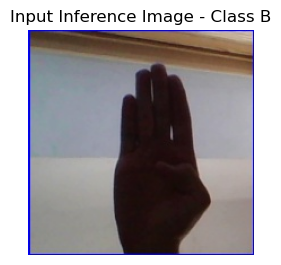

In [6]:
# Load an image
image1_correct_inference_path = '../datasets/inference_test_data/B_test.jpg'
image1_correct_inference_B_label = cv2.imread(image1_correct_inference_path)


# Preprocess the image
processed_image = data_transforms(image1_correct_inference_B_label).unsqueeze(0) 

# Predict using your model
with torch.no_grad():
    prediction = model(processed_image)

# Get the predicted index
predicted_index = torch.argmax(prediction, dim=1)

# Display inference test image
image1_correct_inference_B_label = cv2.cvtColor(image1_correct_inference_B_label, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,1)
plt.title("Input Inference Image - Class B")
plt.axis('off')
plt.imshow(image1_correct_inference_B_label)

print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
print(f'Predicted Class: {predicted_index.item()}')



#### Correct Inference Example 2 - Class C

Predicted Label: C
Predicted Class: 2


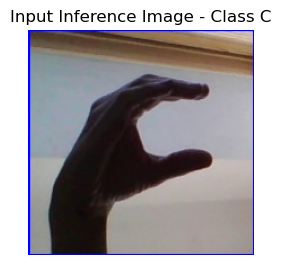

In [7]:
# Load an image
image2_correct_inference_path = '../datasets/inference_test_data/C_test.jpg'
image2_correct_inference_C_label = cv2.imread(image2_correct_inference_path)


# Preprocess the image
processed_image = data_transforms(image2_correct_inference_C_label).unsqueeze(0) 

# Predict using your model
with torch.no_grad():
    prediction = model(processed_image)

# Get the predicted index
predicted_index = torch.argmax(prediction, dim=1)

# Display inference test image
image2_correct_inference_C_label = cv2.cvtColor(image2_correct_inference_C_label, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,1)
plt.title("Input Inference Image - Class C")
plt.axis('off')
plt.imshow(image2_correct_inference_C_label)

print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
print(f'Predicted Class: {predicted_index.item()}')

#### Correct Inference Example 3 - Class D

Predicted Label: D
Predicted Class: 3


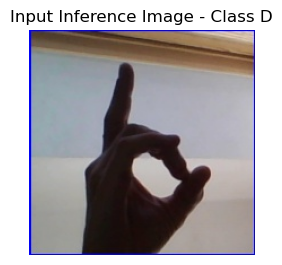

In [8]:
# Load an image
image3_correct_inference_path = '../datasets/inference_test_data/D_test.jpg'
image3_correct_inference_D_label = cv2.imread(image3_correct_inference_path)


# Preprocess the image
processed_image = data_transforms(image3_correct_inference_D_label).unsqueeze(0) 

# Predict using your model
with torch.no_grad():
    prediction = model(processed_image)

# Get the predicted index
predicted_index = torch.argmax(prediction, dim=1)

image3_correct_inference_D_label = cv2.cvtColor(image3_correct_inference_D_label, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,1)
plt.title("Input Inference Image - Class D")
plt.axis('off')
plt.imshow(image3_correct_inference_D_label)

print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
print(f'Predicted Class: {predicted_index.item()}')

## Incorrrect Inferences Examples

#### Incorrect Inference Example 1

Predicted Label: M
Predicted Class: 13


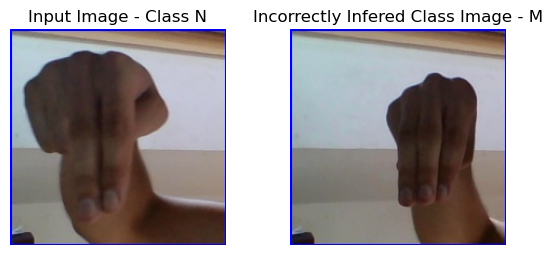

In [9]:
# Load an image
image5_incorrect_inference_path = '../datasets/inference_test_data/N_test.jpg'
image5_incorrect_inference_N_label = cv2.imread(image5_incorrect_inference_path)


# Preprocess the image
processed_image = data_transforms(image5_incorrect_inference_N_label).unsqueeze(0) 

# Predict using your model
with torch.no_grad():
    prediction = model(processed_image)

# Get the predicted index
predicted_index = torch.argmax(prediction, dim=1)

image5_incorrect_inference_N_label = cv2.cvtColor(image5_incorrect_inference_N_label, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,1)
plt.title("Input Image - Class N")
plt.axis('off')
plt.imshow(image5_incorrect_inference_N_label)

print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
print(f'Predicted Class: {predicted_index.item()}')


j_class_image_path = '../datasets/training_data/M/M25.jpg'
j_class_image = cv2.imread(j_class_image_path)
j_class_image = cv2.cvtColor(j_class_image, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,2)
plt.title("Incorrectly Infered Class Image - M")
plt.axis('off')
plt.imshow(j_class_image)
plt.subplots_adjust(wspace=0.3)


#### Incorrect Inference Example 2

Predicted Label: I
Predicted Class: 9


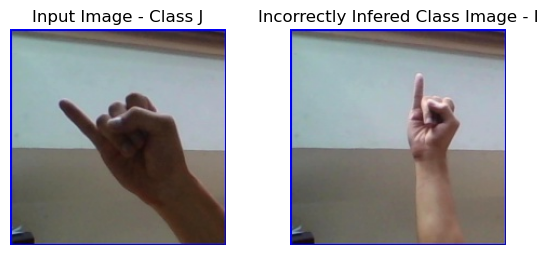

In [10]:
# Load an image
image4_incorrect_inference_path = '../datasets/inference_test_data/J_test.jpg'
image4_incorrect_inference_J_label = cv2.imread(image4_incorrect_inference_path)


# Preprocess the image
processed_image = data_transforms(image4_incorrect_inference_J_label).unsqueeze(0) 

# Predict using your model
with torch.no_grad():
    prediction = model(processed_image)

# Get the predicted index
predicted_index = torch.argmax(prediction, dim=1)

image4_incorrect_inference_J_label = cv2.cvtColor(image4_incorrect_inference_J_label, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,1)
plt.title("Input Image - Class J")
plt.axis('off')
plt.imshow(image4_incorrect_inference_J_label)

print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
print(f'Predicted Class: {predicted_index.item()}')


j_class_image_path = '../datasets/training_data/I/I196.jpg'
j_class_image = cv2.imread(j_class_image_path)
j_class_image = cv2.cvtColor(j_class_image, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,2)
plt.title("Incorrectly Infered Class Image - I")
plt.axis('off')
plt.imshow(j_class_image)
plt.subplots_adjust(wspace=0.3)

# Discussion, Analysis of Results and Areas For Improvement

### Training Process

While the training process for the two models we implemented were relatively straight forward, there was a stark difference between the training time of the two models. The total training time for the KeyPointsNet model was at most 3 seconds using local machine cpu, whereas the training time for the CNN model took closer to 13 minutes, with the use of kaggle GPUs. The distinct contrast in training times between the two models highlights the significant impact of computational resources on deep learning tasks. The KeyPointsNet model, which took only about 3 seconds to train on a laptop's CPU, demonstrates efficiency, accessibility and even slightly better final epoch test accuracy of 98%. In contrast, the more complex CNN model required approximately 13 minutes to train on Kaggle's GPUs, a duration that underscores the model's computational demands. This comparison emphasises the practical advantages of using the KeyPointsNet model, especially when GPU resources are not available. For users with limited access to advanced hardware like GPUs, the KeyPointsNet model offers a more feasible and time-efficient solution which achieves almost the same accuracy of the CNN model. It enables the execution of machine learning tasks with minimal hardware requirements, ensuring broader accessibility and quicker turnaround times. This makes the KeyPointsNet model particularly advantageous for scenarios where rapid development and testing are necessary or in environments with limited computational power. The pre-processing step was more complicated for the KeyPointsNet model however, as we had to write a program to extract the keypoints for each of the images, save them as separate csv files and then import those again in the KeyPointsNet model program. This approach for the pre-processing data for the KeyPointsNet model is much more tedious and prone to bugs in contrast to the relatively small number of pre-processing steps we took to prepare the data for the CNN, highlighting another advantage of the CNN model model approach.

### Inference Results and Comparison with SOTA Approaches

In the inference evaluation of our trained CNN model, we can see both its strengths and areas for improvement. The model correctly classifies gestures for letters A, B, and C, demonstrating its effectiveness in distinguishing among various sign language gestures. These successful inferences highlight the model's capability to capture and interpret the distinct features of these specific gestures. The ability to also classify images with no sign language gestures ("nothing" class) is also a part of our model, class 15 to be exact. This is also another advantage of the CNN model over the KeyPointsNet model where if there are no keypoints to extract from an input image, the KeyPointsNet model cannot classify these "nothing" class images correctly. Where the CNN model correctly infers the C and D images, the KeyPointsNet model cannot find keypoints on these same images, highlighting the advantage of the CNN model over the KeyPointsNet model when it receives these sorts of gestures as inputs.

However, the model also shows limitations in distinguishing between extremely similar gestures, as evident in two instances of incorrect inference. For the first incorrect inference example the model misclassifies the gesture for letter N as letter M. This error likely arises from the subtle difference between these gestures, where the N gesture includes two fingers and the M gesture include 3 fingers but the angle and the position at which the rest of hand is in, is identical. As the dataset is already of substantial size, to overcome this problem and improve the CNN's ability to distinguish smaller details and separate class instances better, the architecture of the CNN could be improved and include more convolutional layers. This will extend the model's ability to learn more information from the input images, leading to the model learning more nuanced differences between similar gestures. If the user decides to take this approach, they should be aware of the possibility of overfitting as a result of addition convolution layers and the increase in the model complexity.

For the second incorrect inference example, the model confuses the gesture for letter J with letter I. This mistake, can not only be attributed to the extremely high degree of similarity between the two gestures (they are identical), but also the nature of the J gesture as it is a dynamic hand gesture and not a static one. This highlights the biggest limitations of our model. It is here that we can also highlight the advantage of the KeyPointsNet model that can actually distinguish between the "J" and "I" class gestures which is extremely impressive. This is likely due to the type of data that the KeyPointsNet model was trained on. As we directly feed in the co-ordinates of the keypoints of a hand in an image, subtle yet significant changes in hand positions are learned with greater accuracy and translate to better inference for these cases when compared to the CNN's autonomous feature learning capabilities. This makes the KeyPointsNet model more sensitive to dynamic classification requirements and produces better results like in this case. The CNN model's inability to consume and process temporal data however leads it to mis-classify gestures of dynamic nature. To overcome this issue, we recommend that users explore and research 3D Convolutional Neural Networks, as mentioned in our report. 3D CNNs not only possess the same advantages as 2D CNNs, such as automated feature extraction, spatial hierarchical learning, and parameter efficiency, but they are also capable of processing temporal data. This makes them more suited for dynamic classification tasks, such as recognising the J gesture in a time-based context. Again however, there are 3 key factors that viewers should consider if they do take the 3D CNN approach. These factors are: 
- The increased risk of overfitting due to the fact that 3D CNNs have a higher number of parameters compared to 2D CNNs, which increases the model's complexity and as a result increases chance of overfitting.
- The need for increased computational resources as due to their nature, 3D CNNs are more computationally intensive. They require more memory and processing power, which can significantly increase training time and demand higher-end hardware, like powerful GPUs.
- The requirement for specific volumetric data like video rather than images and the challenges that come with the availability of this type of data.

In conclusion, while the CNN model demonstrates high accuracy and performance, challenges in inference on sample gestures that share common features with other classes suggests area for improvement. Addressing these challenges by adding more convolutional layers and a smaller kernel size to extract finer details could enhance this architecture's ability to distinguish smaller features and lead to an overall better inference performance.


